<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

<center>Author: Alexey Serov (@fanvacoolt)

# <center> Using `hyperopt` for hyperparameters optimization

Sooner or later (most likely sooner) in machine learning we all come to the phase of model hyperparameters tuning. Even the most simple linear models, like logistic regression, could benefit from properly chosen regularization coefficient, and for more complex ones the efficiency gain could be even more dramatic. 

Hyperparameters are set by a data scientist, and there is no definitive way to know beforehand which values are optimal (though there are some heuristics to ease the search). You can only try different values and see which one is best.
There are three classic ways to do this:
  - **Grid search**, implemented, for example, in `GridSearchCV` class from `sklearn.model_selection` module. No doubt you know it already. Just feed in the model, the list of parameters you want to tune plus their possible values and the data, along with cross-validation scheme and desired metrics, and go get some coffee while it crunches all possible combinations of hyperparameters. This could take a **LONG** time even for simpler models.
  - **Random search**. Implementation could be found in `RandomizedSearchCV` class from `sklearn.model_selection` module. The name speaks for itself - feed it the same data, only this time you might not only list the values, but give distributions as well - and it will sample random points from hyperparameters space. Not guaranteed to find the best combination, but is deemed much more cost-effective than grid search.
  - **Numerical optimization**. There are many algorithms for numerical search of a function minimum (most well known to us is gradient descent); however, they are poorly suited for hyperparameters optimization. These algorithms are usually intended to minimize functions like $f:\mathbb{R}^n\to\mathbb{R}$, while hyperparameters spaces might have both real-valued and discrete components, and even have distinct dimensionalities for different hyperparameters choice.

Of these the random search usually shows the best results when time is limited. Grid search is guaranteed to find the best possible combinations of those you've given it, but it might take forever. And even the best possible combination might be far from optimal. Each time you make the grid more dense or expand the borders - the computation time grows as well.

Unfortunately, common implementation of random search completely ignores information on the trials already computed, and each new sample is drawn from the same initial distribution. Fortunately, there is a way to account for them. Say, you were tuning $C$ - regularization parameter for logistic regression. If one particular value gives really bad results - the points in vicinity will also perform poorly, so there is really very little need to sample from this region. We would like to incorporate this information into our strategy - in other words, we want to get more points from the regions with high probability of yielding good result and get less points from elsewhere. That's exactly what `hyperopt` module can do.

## Importing modules

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import multivariate_normal, binom

from functools import partial

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns

%matplotlib inline

from IPython.display import HTML

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# ================================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

from sklearn import datasets
from sklearn.utils import shuffle

## Introducing `hyperopt`

Let's consider a toy example for a start. We'll take the following function in 2D plane:

$$f(x, y) = 5e^{-\frac{(x - 3)^2 + (y - 4)^2}{4}} + 2e^{-\frac{\sqrt{(x + 3)^2 + (y - 3)^2}}{2}} + e^{-\sin\left({\sqrt{(x - 5)^2 + (y + 3)^2}}\right)},$$

and see how different methods look for it's maximum.

### Running different optimization methods

#### Defining toy function and meshgrid for plotting

In [2]:
# Seed for pseudo-random generator
SEED = 21

# Plotting limits
x_limits = (-10, 10)
y_limits = (-10, 10)

# --------------------------------

# Toy function
fct = lambda x, y: 5*np.exp(-((x - 3)**2 + (y - 4)**2)/4) + \
                   2*np.exp(-np.sqrt((x + 3)**2 + (y - 3)**2)/2) + \
                   1*np.exp(-np.sin(np.sqrt((x - 5)**2 + (y + 3)**2)/1))

# Defining mesh
xy_mesh = np.meshgrid(np.linspace(*x_limits, 2001), np.linspace(*x_limits, 2001))
fct_mesh = fct(xy_mesh[0], xy_mesh[1])

#### Plotting function graph

Let's build a contour plot to see how our function behaves in region $[-10, 10]\times[-10, 10]$.

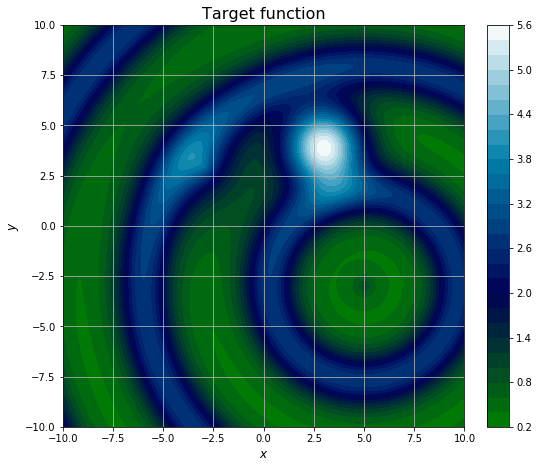

In [3]:
fig0 = plt.figure(figsize=(8, 8))

cntr = plt.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
_ = fig0.colorbar(cntr, ax=plt.gca(), fraction=0.05, pad=0.05, aspect=18)

plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Target function', fontsize=16)

plt.gca().grid(True)
plt.gca().set_aspect('equal')

The function has a global maximum somewhere around $(3, 4)$ and local maximum somewhere close to $(-3.5, 3.5)$. Now we'll perform a grid search, a random search, a numerical maximization using [L-BFGS-B method](https://en.wikipedia.org/wiki/Limited-memory_BFGS) and hyperopt optimization.

Say, for some reason we know nothing of variable $x$, we are only sure that it is constrained to $[-10, 10]$ interval, but we have strong evidence saying that maximum point of $y$ is more likely to lie closer to $0$. For stochastic algorithms (Random Search and hyperopt), we will assign uniform prior distribution to $x$ and normal to $y$: 
$$x \sim \mathrm{U}[-10, 10], y \sim \mathcal{N}(0, 5).$$

#### Grid Search and Random Search

In [4]:
# Number of points in Grid Search per coordinate
n_pts = 14

# Building GS grid and evaluating function
xy_GS = np.meshgrid(np.linspace(*x_limits, n_pts), np.linspace(*y_limits, n_pts))
fct_GS = fct(xy_GS[0], xy_GS[1])

# Best point obtained by Grid Search
best_GS = (fct_GS.max(), (xy_GS[0].flatten()[fct_GS.argmax()], 
                          xy_GS[1].flatten()[fct_GS.argmax()]))

# --------------------------------

# Setting up random seed for reproducibility
np.random.seed(SEED)

# Sampling points from prior distributions for x and y
y_std = 5
xy_RS = [np.random.uniform(*x_limits, n_pts**2).reshape(n_pts, n_pts), 
         np.random.normal(0, y_std, n_pts**2).reshape(n_pts, n_pts)]
fct_RS = fct(xy_RS[0], xy_RS[1])

# Best point obtained by Random Search
best_RS = (fct_RS.max(), (xy_RS[0].flatten()[fct_RS.argmax()], 
                          xy_RS[1].flatten()[fct_RS.argmax()]))

#### Performing numerical optimization

In [5]:
# Initial guess and list of traversed points
xy_M = [(0.0, 0.0)]

# Function to dump current point in minimization algorithm to list
def f_current_point(x):
    xy_M.append(x)
    return None

# Starting maximization (minus sign since most optimization problems are 
# formulated in terms of finding minimum)
res_M = minimize(lambda x: -fct(*x), x0=xy_M[0], method='L-BFGS-B', 
                   bounds=[x_limits, y_limits], options={'maxiter': n_pts**2}, 
                   callback=f_current_point)

print(res_M)

# Best point obtained by L-BFGS-B
xy_M = np.array(xy_M).T
best_M = (-res_M.fun, res_M.x)

      fun: -5.540910223655629
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.59872116e-06, -1.46549439e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 11
   status: 0
  success: True
        x: array([3.01370181, 3.88382844])


From the report we see that maximum indeed is close to $(3, 4)$, and it took $69$ function evaluations to converge, even if there are only $11$ iterations.

#### `hyperopt` optimization

**NOTE**: I am not giving here a detailed description of how to set up hyperopt optimization - this section is intended purely to demonstrate how it works. It will be fully covered in subsequent sections, when we solve a machine learning hyperparametes tuning problem. For now, you can safely ignore all the unfamiliar code.

In [6]:
# Setting up hyperparameters space
hp_space = {'x': hp.uniform('x', *x_limits), 
            'y': hp.normal('y', 0, 5)}

# Setting up number of evaluations and Trials object
n_evals = n_pts**2
trls = Trials()

# Running optimization
res_HO = fmin(lambda hps: -fct(hps['x'], hps['y']), space=hp_space, algo=tpe.suggest, 
                trials=trls, max_evals=n_evals, rstate=np.random.RandomState(SEED))

# Restoring search history and best point
xy_HO = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
         np.array([x['misc']['vals']['y'] for x in trls.trials])]
best_HO = (-trls.best_trial['result']['loss'], (space_eval(hp_space, res_HO)['x'], 
                                                space_eval(hp_space, res_HO)['y']))

100%|██████████| 196/196 [00:00<00:00, 218.33it/s, best loss: -5.528460905856665]


### Analyzing results

All right, now let's see what we've got. We'll plot search history of all four methods, points distribution on 2D plane and compare the results.

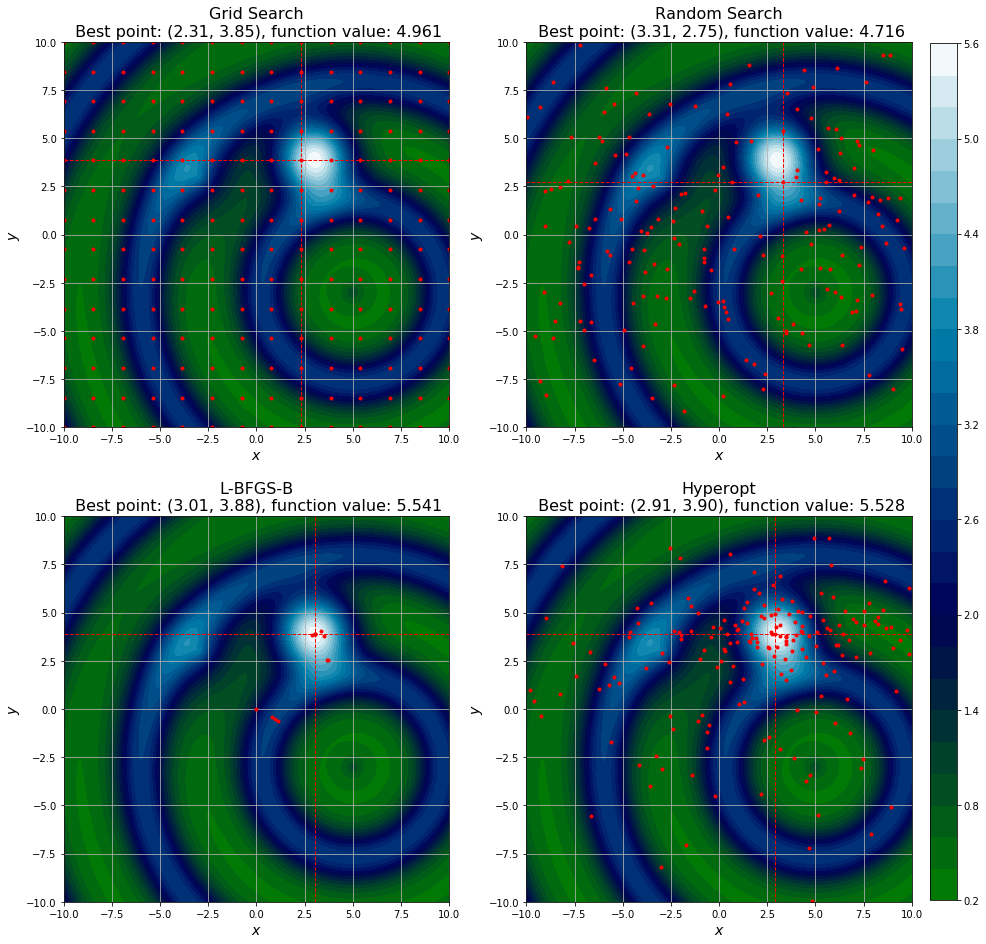

In [7]:
# Setting up layout and graph labels
fig0, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 16))
labels = ('Grid Search', 'Random Search', 'L-BFGS-B', 'Hyperopt')

# Plotting
for (xy, xlabel, xbest, ax) in zip((xy_GS, xy_RS, xy_M, xy_HO), 
                                   labels, 
                                   (best_GS, best_RS, best_M, best_HO), 
                                    axs.flatten()):
    # Function contour and points from search history
    cntr = ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    ax.plot(xy[0], xy[1], linewidth=0, marker='.', color='red')
    
    # Marking best result
    ax.plot(x_limits, [xbest[1][1]]*2, linewidth=1, linestyle='--', color='red')
    ax.plot([xbest[1][0]]*2, y_limits, linewidth=1, linestyle='--', color='red')
    
    # Formatting axes
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    ax.set_xlabel('$x$', fontsize = 14)
    ax.set_ylabel('$y$', fontsize = 14)
    
    ax.set_title('{0}\n Best point: ({1:.2f}, {2:.2f}), function value: {3:.3f}'.format(
        xlabel, *xbest[1], xbest[0]), fontsize=16)
    
    ax.grid(True)
    ax.set_aspect('equal')

# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=32)

Well-well-well. What do we have here?
  - **Grid Search** is pretty straightforward - a uniform mesh over the hyperspace, best point not far from global maximum;
  - **Random Search** performed rather poorly - majority of points concentrated in areas of low function value; it also gave worst result here;
  - **Numerical maximization** converged to global maximum - quite expected, since it was solving the problem it was designed to solve. Best result;
  - **Hyperopt** has high points density around global maximum, and, in fact, performed almost as good as numerical maximization - $5.528$ against $5.541$.
  
From the graphs one can easily see the idea behind hyperopt - regions in hyperspace, points from which performed better get higher chance to be sampled from again. We'll illustrate this in more detail once more by showing the evolution of hyperopt sampling strategy as number of points grows.

### Visualizing hyperopt sampling strategy

Let's run hyperopt for some time and see how sampling distribution evolves for both `hyperopt` and random search.

#### Gathering sample points

In [8]:
steps = 2000

trls = Trials()
trls_random = Trials()

# ----------------

res_HO = fmin(lambda hps: -fct(hps['x'], hps['y']), space = hp_space, algo = tpe.suggest, 
              trials = trls, max_evals = steps, rstate = np.random.RandomState(SEED))

xy_HO2 = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls.trials])]


res_RS = fmin(lambda hps: -fct(hps['x'], hps['y']), space = hp_space, algo = tpe.rand.suggest, 
              trials = trls_random, max_evals = steps, rstate = np.random.RandomState(SEED))

xy_RS2 = [np.array([x['misc']['vals']['x'] for x in trls_random.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls_random.trials])]

100%|██████████| 2000/2000 [00:04<00:00, 475.74it/s, best loss: -5.509502038738186]


We'll animate the results to look at each generation separately.

#### Setting up animation

In [9]:
# Setting up figure
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
labels = ['Random Search', 'Hyperopt']

# Setting up animation frames
n_frames = 20
n_frame_pts = steps//n_frames

# Initial axes formatting
for (ax, xlabel) in zip(axs.flatten(), labels):
    ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    
    ax.set_xlim(x_limits)
    ax.set_xlim(y_limits)
    
    ax.set_title(xlabel, fontsize=16)
    
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14)

    ax.grid(True)
    ax.set_aspect('equal')
    
# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=15)

# Points and iteration indicator are the only things that change
pts0 = axs[0].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
pts1 = axs[1].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
fig0_tl = fig0.suptitle('Batch {0}'.format(0), fontsize=18)


def f_update_anim(frame, n_frames):
    """
    TODO
    """
    
    # Determine indexes of points within iteration
    idx0 = int(frame*len(trls)/n_frames)
    idx1 = int((frame + 1)*len(trls)/n_frames)
    
    # Plot new data
    pts0[0].set_data(xy_RS2[0][idx0:idx1], xy_RS2[1][idx0:idx1])
    pts1[0].set_data(xy_HO2[0][idx0:idx1], xy_HO2[1][idx0:idx1])
    fig0_tl.set_text('Batch {0}'.format(frame + 1, n_frames))
    
    return pts0[0], pts1[0], fig0_tl

plt.close()

# Set up animation
ani1 = FuncAnimation(fig0, lambda fr: f_update_anim(fr, n_frames), frames=n_frames, interval=500, blit=False)

In [10]:
HTML(ani1.to_jshtml())

All right, now it's even more illustrative (don't forget to press "run" button above). We sampled 2000 points using random search and hyperopt, divided them in batches of 100 and plotted each batch separately. With every passing iteration points tend to cluster around global maximum for hyperopt, while any batch of points for Random Search is indistinguishable from any other (as expected).

All right. I hope by now you understand what does hyperopt do, and why we might want to use it. Let's see what we have to do to make it work, and then we'll apply it to machine learning problems.

## Internal workings of `hyperopt`

Latest version on package is available on PyPi, and can be easily installed with `pip` or `conda`:

In [11]:
# !pip install hyperopt
# !conda install -c conda-forge hyperopt

The [GitHub repo](https://github.com/hyperopt/hyperopt) contains all the necessary documentation and some examples. To set up and run optimization problem you need to import at least the following:

In [12]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

Diving in:
  - **fmin** - central function of `hyperopt`, it performs guided search for a function minimum. It returns the point from parameters hyperspace that yielded the lowest loss. Most important arguments are:
    - *fn* - function to minimize. Must accept a sample from parameters hyperspace and return real number (it might also return a dictionary, which has to contain two mandatory records: *loss* and *status*. Other elements you can design youself, if you want to, say, keep track of some other value during optimization. More on that later);
    - *space* - parameters hyperspace to sample from;
    - *algo* - algorithm which suggests new point given the points history. There are two options - `tpe.suggest` (guided search) and `tpe.rand.suggest` (essentially random search. If you want it);
    - *max_evals* - number of points to sample;
    - *trials* - object of class `Trial` to keep track of optimization history;
    - *rstate* - pseudo-random generator seed, analogous to `random_state` from `sklearn`, for reproducibility;
    - *show_progressbar* - well, kind of explains itself, doesn't it?
  - **hp** - submodule to construct parameters hyperspace;
  - **tpe** - submodule, which component `tpe.suggest` is the heart on hyperopt. It is an algorithm for guided points sampling, named Tree of Parzen Estimators;
  - **Trials** - class, instances of which keep track of entire optimization process (stuff like parameters values, loss values, etc.);
  - **space_eval** (*optional*) - sometimes useful for restoring parameters values from hyperspace in case of complex hyperspaces;
  - **scope** - (*optional*) - submodule, among other things used for parameters type transformation. Say, you draw something from normal distribution, which comes out as `float`, but your model accepts only integer types - `scope` rushes for help;
  - **sample** - (*optional*) - function to draw sample from hyperspace. Not required, but useful for testing whether you described your hyperspace correctly before running `fmin`.

### Defining search space

One of the most exciting features of `hyperopt` is it's ability to design search spaces of arbitary complexity. You can mix real-valued parameters, integers, boolean variables and even strings, and you can also specify some prior information you have on them in form of probability distribution.

On Github repo there is a [basic tutorial](https://github.com/hyperopt/hyperopt/wiki/FMin) which covers essential steps to some extent.

Simplest example. You are optimizing regularization parameter $C$ for Logistic Regression. Your one-dimensional hyperspace might be determined as follows:

In [13]:
hp_space = hp.uniform('C', low=0.01, high=100)

Obviously, this represents prior info that $C$ is uniformly distributed on interval $[0.01, 100]$. However, this is not the best prior for $C$. What is more important is the magnitude of $C$, so let's instead set up our prior as uniformly distributed logarithm:

In [14]:
hp_space = hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))

All right, now our prior for $C$ has a logarithm uniformly distributed on $[-4\ln{10}, 4\ln{10}]$, and $C$ is constrained to $[10^{-4}, 10^{4}]$.

Say, you decided to switch to Random Forest. It has many parameters you might tune. Suppose you want to tune number of trees, optimization criterion and number of features for bagging. Let's do it:

In [15]:
hp_space = {
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=300, q=25)), 
    'criterion': hp.choice('criterion', ['gini', 'entropy']), 
    'max_features': hp.uniform('max_features', low=0.25, high=0.75)
}

We used here `hyperopt.pyll.scope.int` function, because `hp.quniform` returns real value, even if it is quantified by integer.

Note that when our parameter search space is multidimensional - we define it as dictionary. There are two label per each parameter - key of a dictionary and label inside `hp.***` distribution. You can name them as you please, but keep in mind that duplicate labels are not allowed.

`hyperopt.pyll.stochastic.sample` draws a random point from search space, as you can see below.

In [16]:
ho_sample(hp_space)

{'criterion': 'gini', 'max_features': 0.5562730255127579, 'n_estimators': 150}

One last example to show you how you can construct complex hyperspaces. Say, you are not sure which classifier to use - Random Forest or Logistic Regression. You can treat it as a hyperparameter as well. We can define additional `type` parameter like this:

In [17]:
hp_space = {
    'type': hp.choice('type', [
        {
            'type': 'logit', 
            'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))
        }, 
        {
            'type': 'random_forest', 
            'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=300, q=25)), 
            'criterion': hp.choice('criterion', ['gini', 'entropy']), 
            'max_features': hp.uniform('max_features', low=0.25, high=0.75)
        }
    ])
}

ho_sample(hp_space)

{'type': {'C': 18.407241275416524, 'type': 'logit'}}

Easy, right? Now if hyperopt draws `logit` - your hyperspace will be one-dimensional, but when it is `random_forest` - it will have three parameters (well, actually, 2 and 4 since `type` is also a parameter, albeit constant for each classifier).

Theoretically speaking, there is no limit of hyperspace complexity, however, bear in mind that it might take a lot of samples to properly inspect extremely complex ones, even with hyperopt.

### Target function

Which function do we pass to `fmin` as target? Well, since we are in machine learning business, and aim to pick best possible hyperparameter combination - our function must accept a sample from hyperspace and return desired metric value. In other words, it receives a set of hyperparameters values, creates model, then runs cross-validation and returns mean metric value, or fits model on training set and returns metric on validation set - it is you who determines this.

**HINT**: You must understand which value of selected metric is better, and keep in mind that `fmin` will attempt to minimize it. If you run regression, then you want your RMSE as low as possible - no tricks there. But if you run classification - the higher your ROC-AUC, the better, so don't forget the minus sign! Otherwise you'll get what you asked for - the set of hyperparameter values that yield the worst performance :).

### Tree of Parzen Estimators (TPE)

This is the algorithm used to adjust probability density in search space based on target function evaluation history. The internal workings of it are well beyond the scope of this tutorial. Describing it in two words: it uses bayesian approach to update posterior hyperparameters distribution. If you would like to dive in - [here](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) is a good start.

### `Trials` object

Instances of this class keep track of optimization history, recording all drawn points and function evaluation results. It is not mandatory to use it, but highly advisable.

All right, enough with the theory. Let's run some models!

## Using `hyperopt` to tune model hyperparameters.

We'll practice on rather simple problem. We'll generate points of two classes from known distribution, which is a mixture of two 2-D normal distributions.

### Generating samples

Here we're defining our own functionality to draw samples (seems simpler than trying to make `sklearn` generate what you need in 2D space).

###### Function to draw samples

In [18]:
# Defining mixture distributions
dists = [
    [
        (0.5, multivariate_normal(mean=[0.0, 0.5], 
                                  cov=[[1.0, -0.8], 
                                       [-0.8, 3.0]])), 
        (0.5, multivariate_normal(mean=[6.5, 0.0], 
                                  cov=[[1.0, 0.9], 
                                       [0.9, 2.0]]))
    ], 
    [
        (0.3, multivariate_normal(mean=[2.0, 6.0], 
                                  cov=[[1.0, 0.5], 
                                       [0.5, 2.0]])), 
        (0.4, multivariate_normal(mean=[4.0, 2.0], 
                                  cov=[[1.0, 1.5], 
                                       [1.5, 5.0]])), 
        (0.3, multivariate_normal(mean=[7.0, 6.0], 
                                  cov=[[1.0, 0.3], 
                                       [0.3, 1.0]]))
    ]
]

# Class weights
weights = np.array([0.75, 0.25])

# ================================

def f_sample_from_mixture(mix_dist, n_samples=1, random_state=None):
    """
    Draws sample points from mixture of different distributions
    
    Parameters:
    ----------------
    mix_dist : list of tuples (w, d), where w is relative weight of distribution, d is scipy distribution
        object (which has rvs() method to draw sample). NOTE: w's must sum to 1!
    n_samples : int, number of samples to draw from mixed distribution
    random_state : int, NumPy pseudo-random generator seed
    
    Returns:
    ----------------
    NumPy array of shape (n_samples, x), where each row is a sample point. x is determined by dimensionality
        of distributions
    """
    
    # Setting preudo-random generator seed
    if not random_state is None:
        np.random.seed(random_state)
    
    # Drawing particular distribution component from which further to draw a point
    dkeys = np.random.choice(range(len(mix_dist)), size=n_samples, replace=True, 
                             p=[x[0] for x in mix_dist])
    
    res = []
    
    # Drawing samples from mixture components
    for (xkey, xdist) in enumerate(x[1] for x in mix_dist):
        res.append(xdist.rvs(size=(dkeys == xkey).sum()))
    
    # Shaking up samples
    return np.random.permutation(np.vstack(res))

###### Drawing samples

We'll generate $5000$ points.

In [19]:
n_samples = 5000

np.random.seed(SEED)

# Drawing number of objects of class 1 then generating features and class labels
n_class1 = np.random.binomial(n=n_samples, p=weights[1])
X1 = np.vstack([
    f_sample_from_mixture(dists[0], n_samples - n_class1, SEED), 
    f_sample_from_mixture(dists[1], n_class1, SEED)
])
y1 = np.hstack([np.zeros(n_samples - n_class1), np.ones(n_class1)])

# Shuffling samples (otherwise we have all 0's followed by all 1's)
X1, y1 = shuffle(X1, y1, random_state=SEED)

### Plotting samples and splitting dataset into train, validation and test subsets

Since there are only two features, we can easily visualize them on 2D plane.

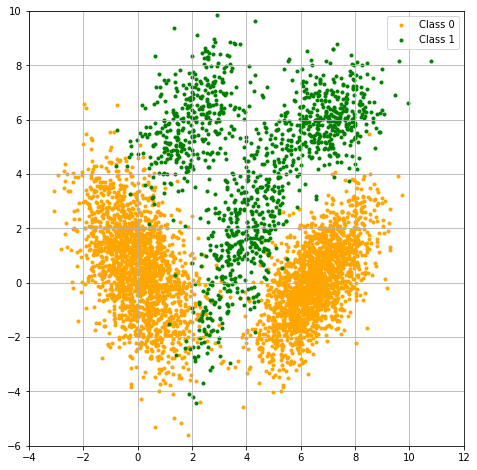

In [20]:
# Define plotting boundaries for later, and meshgrid for contour plots
xlim2 = (-4, 12)
ylim2 = (-6, 10)

xy_mesh2 = np.meshgrid(np.arange(xlim2[0], xlim2[1] + 0.01, 0.01), \
                       np.arange(ylim2[0], ylim2[1] + 0.01, 0.01))

# Reshaping meshgrid into shape that we can pass to classifier from sklearn
xy_mesh2_features = np.array([xy_mesh2[0].ravel(), xy_mesh2[1].ravel()]).T

# --------------------------------

# Plotting sampled points
plt.figure(figsize=(8, 8))
flag = y1 == 1

plt.scatter(X1[~flag, 0], X1[~flag, 1], label='Class 0', marker='.', color='orange')
plt.scatter(X1[flag, 0], X1[flag, 1], label='Class 1', marker='.', color='green')

plt.xlim(xlim2)
plt.ylim(ylim2)

plt.gca().set_aspect('equal')
plt.gca().grid(True)
plt.legend()

Classes are not linearly separable, so there seems to be enough space for hyperparameters tweaking.

We split dataset into train and validation parts.

In [21]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=1500, 
                                                        stratify=y1, random_state=SEED)

print('Test set size: {0}x{1}'.format(*X1_test.shape))
print('Training set size: {0}x{1}'.format(*X1_train.shape))

Test set size: 1500x2
Training set size: 3500x2


### Case 1: logistic regression with polynomial features

Fitting linear logistic regression is no fun. It has only one and a half parameter to tweak, so we won't see much action there. 

It is clear that our dataset has highly non-linear separation boundary. We will take this into account by adding polynomial features to our classifier. We also won't forget that linear models are sensitive to features magnitudes, hence a pipeline with a scaler would be desirable.

So we create a 3-dimensional search space: degree of polynomial features, which for now we assume can be either $1$ or $2$, logit regularization constant $C$ and `class_weight` parameter, since we have a slight classes disbalance.

#### Defining search space

In [22]:
hp_space_clf1 = {
    'poly': {
        'degree': 1 + hp.randint('degree', 1 + 1)
    }, 
    'clf': {
        'C': hp.loguniform('C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
        'class_weight': hp.choice('class_weight', [None, 'balanced'])
    }
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_clf1)

{'clf': {'C': 13.585760456811155, 'class_weight': 'balanced'},
 'poly': {'degree': 2}}

Here we separated parameters for polynomial feature generation for the sake of more clear and concise code. Note how `degree` parameter is implemented: `hp.randint(label, x)` returns random integer between $0$ and $x - 1$, we have to manually add 1 to result (`degree == 0` doesn't make any sense, while `degree == 1` means no polynomial features). Any mathematical expression is permitted with sampled values. $C$ initially has loguniform distribution, and `class_weight` is a discrete random variable with two options.

**NOTE**: here `degree` assumes either $1$ or $2$, so we could have easily implemented it with `hp.choice`; however `hp.randint` suits better here, since we're dealing with ordinal numbers, and order actually has meaning here.

Now, let's implement model constructor.

#### Defining model

In [23]:
def f_clf1(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # Assembing pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(**hps['poly'], include_bias=False)), 
        ('scale', StandardScaler()), 
        ('clf', LogisticRegression(**hps['clf'], solver='liblinear', max_iter=25000, random_state=SEED))
    ])
    
    return model

Note, that since we labeled our hyperparameters with the same keywords as they passed to estimator or transformer constructor - we can just use unpacking operator `**`, without using explicit statements like `LogisticRegression(C=hps['C'], ...`. It is a good practice to ensure you wont't forget to pass a hyperparameter value to model.

#### Defining target function

Ok, now we have to define function to minimize. We'll stick with cross-validation score on train set. Our function should take a sample from search space and return negative mean ROC-AUC score. As noted above, it is very important to return negative score here, since otherwise we'll seek for hyperparameters that minimize ROC-AUC.

In [24]:
def f_to_min1(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : target function value (negative mean cross-val ROC-AUC score)
    """
    
    model = f_clf1(hps)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, random_state=SEED), 
                             scoring='roc_auc', n_jobs=-1)
    
    return -cv_res.mean()

#### Running optimization

All right, let's run optimization for 100 rounds using TPE algorithm, meaning that we use TPE to suggest next sample values based on previous function evaluations. We'll use `Trials` class objects to keep track of optimization history.

**Note**: We're binding `X` and `y` arguments of target function to `X1_train` and `y1_train` respectively, using `functools.partial`, since target function of `fmin` may accept only a search space point.

In [25]:
trials_clf1 = Trials()
best_clf1 = fmin(partial(f_to_min1, X=X1_train, y=y1_train), 
                 hp_space_clf1, algo=tpe.suggest, max_evals=100, 
                 trials=trials_clf1, rstate=np.random.RandomState(SEED))

100%|██████████| 100/100 [00:09<00:00, 22.35it/s, best loss: -0.9942591394193329]


The classification quality is very high. Seems that our polynomial features are kicking off here!

#### Model performance on test set

In [26]:
# Building and fitting classifier with best parameters
clf1 = f_clf1(space_eval(hp_space_clf1, best_clf1)).fit(X1_train, y1_train)

# Calculating performance on validation set
clf1_val_score = roc_auc_score(y1_test, clf1.predict_proba(X1_test)[:, 1])
print('Cross-val score: {0:.5f}; validation score: {1:.5f}'.\
      format(-trials_clf1.best_trial['result']['loss'], clf1_val_score))
print('Best parameters:')
print(space_eval(hp_space_clf1, best_clf1))

Cross-val score: 0.99426; validation score: 0.99505
Best parameters:
{'clf': {'C': 2.077154576585185, 'class_weight': 'balanced'}, 'poly': {'degree': 2}}


Test set accuracy and cross-validation scores are consistent. We also see that polynomial features of degree 2 are selected as best value.

#### Plotting optimization history

Below are two helper functions that help to deal with how `hyperopt` stores trials. First wraps evaluation history into list of dicts, so we can easily extract parameter we're interested in from it. Second takes a dict and unpacks recursively any nested sub-dicts that it might have, which useful with complex hyperspaces that branch into different subspaces.

In [27]:
def f_wrap_space_eval(hp_space, trial):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    
    return space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})


def f_unpack_dict(dct):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

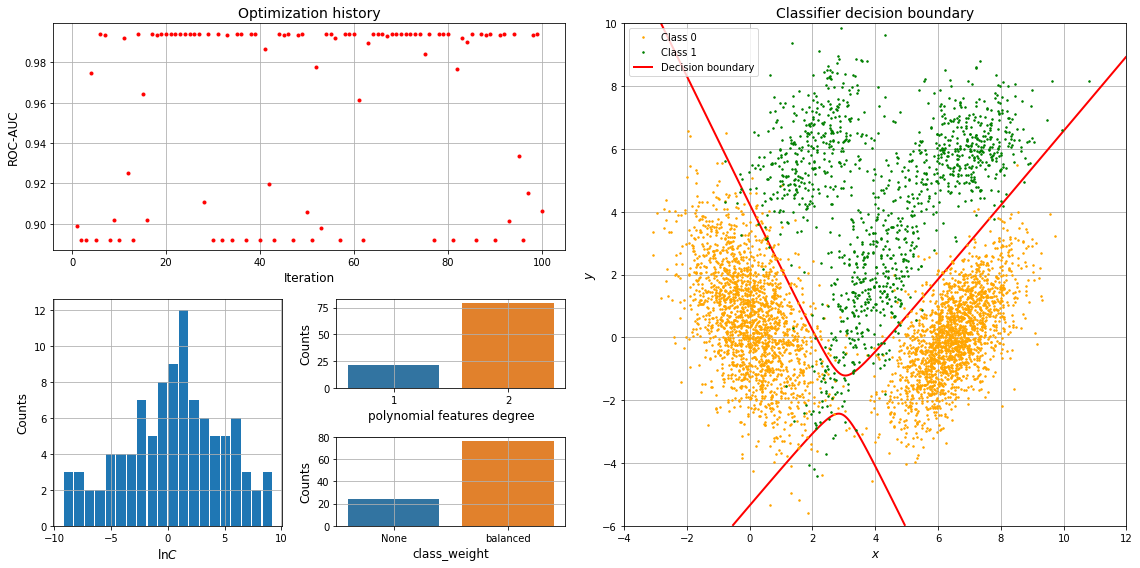

In [28]:
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :2])
ax.plot(range(1, len(trials_clf1) + 1), [-x['result']['loss'] for x in trials_clf1], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf1, x)) for x in trials_clf1.trials]

ax = fig0.add_subplot(gs[2:, 0])
ax.hist(np.log([x['C'] for x in samples]), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('$\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2, 1])
sns.countplot(x=[x['degree'] for x in samples], ax=ax)

ax.set_xlabel('polynomial features degree', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[3, 1])
sns.countplot(x=[str(x['class_weight']) for x in samples], ax=ax)

ax.set_xlabel('class_weight', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ================================
# Plotting decision boundary

ax = fig0.add_subplot(gs[:, 2:])

# plt.contour is a bit tricky with legend labels, so it has to be constructed manually
legends = []

# Scattering sampled points and keeping their legend items
pts_class0, = ax.plot(X1[~flag, 0], X1[~flag, 1], label='Class 0', 
                      linewidth=0, marker='.', markersize=3, color='orange')
legends.append(pts_class0)
pts_class1, = ax.plot(X1[flag, 0], X1[flag, 1], label='Class 1', 
                      linewidth=0, marker='.', markersize=3, color='green')
legends.append(pts_class1)

# Decision boundary is build via plt.contour with single level line = 0.5, legend item added separately
cntr = ax.contour(xy_mesh2[0], xy_mesh2[1], 
                  clf1.predict_proba(xy_mesh2_features)[:, 1].\
                      reshape(xy_mesh2[0].shape[0], -1), 
                  levels = [0.5], colors='red', linewidths=2)
legends.append(cntr.legend_elements()[0][0])

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.set_title('Classifier decision boundary', fontsize=14)

ax.set_xlim(xlim2)
ax.set_ylim(ylim2)

ax.set_aspect('equal')
ax.grid(True)
ax.legend(legends, ['Class 0', 'Class 1', 'Decision boundary'])

# ================================

plt.tight_layout()

We can clearly see the propensity of TPE-driven optimization to sample points with lower target function value. Sampled points histograms are clearly non-uniform, so we see posterior densities adjusted. Note also that sometimes TPE samples points from regions with poor performance, which makes it unlikely to get stuck in local minimum. Win-win!

## Case 2: Choosing between logit and SVM

Adding polynomial features sure helped a lot, but can we push quality even further? We can increase maximum allowable polynomial degree, but how about trying different classifiers? Maybe SVM with RBF kernel? We treat classifier type as hyperparameter as well.

#### Defining search space

Branching search space into subspaces can be done with `hp.choice`. It's elements might be atomic values, or hyperspaces themselves as well!

In [29]:
hp_space_clf2 = {
    # type refers to classifier type: either logit or SVM
    'clf_type': hp.choice('clf_type', [
        {
            'type': 'logit', 
            'poly': {
                'degree': 1 + hp.randint('degree', 3 + 1), 
                'interaction_only': hp.choice('interaction_only', [False, True])
            }, 
            'clf': {
                'C': hp.loguniform('logit.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('logit.class_weight', [None, 'balanced'])
            }
        }, 
        {
            'type': 'SVM', 
            'clf': {
                'C': hp.loguniform('svm.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('svm.class_weight', [None, 'balanced']), 
                'kernel': 'rbf', 
                'gamma': hp.choice('svm.gamma', ['auto', 'scale'])
            }
        }
    ])
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_clf2)

{'clf_type': {'clf': {'C': 20.76714205022748,
   'class_weight': 'balanced',
   'gamma': 'scale',
   'kernel': 'rbf'},
  'type': 'SVM'}}

Now that's a complex hyperspace! It branches into two subspaces of different dimensionalities based on `clf_type`, and these subspaces are quite distinct. Moreover, subspace for SVM branches once more when we choose more appropriate kernel.

**Important notes**:
  - Here we have parameters `C` and `class_weight` in both logit and SVM constructors. Note how we preceded labels in hyperspace elements with prefixes. If we don't do that, we'll get `DuplicateLabel` exception upon trying to run `fmin`. `hyperopt` does not allow this, so each *internal label* (i.e. label within `hp.***` object) must be unique. However, sample from hyperspace is indexed by key values from dictionary, and these might be duplicated without any problem, as long as you don't have repeated keys within one (sub)-dictionary. 
  - Why don't we use a single dimension for `C` instead of making two separate dimensions for each classifier? Well, it is clear that optimal value of `C` for logit might be quite different of that for SVM. Distribution of common `C` gets adjusted with every trial of model, no matter classifier type. Eventually, of course, one of them will prevail, making `C` assume optimal value for it, but do we really need this additional obstacles for algorithm convergence?

#### Defining model

In [30]:
def f_clf2(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    if hps['clf_type']['type'] == 'logit':
        model = Pipeline([
            ('poly', PolynomialFeatures(**hps['clf_type']['poly'], include_bias=False)), 
            ('scale', StandardScaler()), 
            ('clf', LogisticRegression(**hps['clf_type']['clf'], 
                                       solver='liblinear', max_iter=25000, random_state=SEED))
        ])
    elif hps['clf_type']['type'] == 'SVM':
        model = Pipeline([
            ('scale', StandardScaler()), 
            ('clf', SVC(**f_unpack_dict(hps['clf_type']['clf']), probability=True, random_state=SEED))
        ])
    else:
        raise KeyError('Unknown classifier type hyperparameter value: {0}'.format(hps['clf_type']['type']))
    
    return model

We need a little helper function here. If classifier type happens to be SVM - there will be nested sub-dictionaries in it, so we can't use unpacking operator starightaway. `f_unpack_dict` deals with this, unpacking all the nested subdictionaries.

#### Defining target function

We'll also make target function a bit more complex this time. `fmin` can accept functions which return not only a single number but also a dictionary. Two items are mandatory: `'loss'` - target function value, and `'status'`, which tells if function evaluated correctly. We'll add one more value: standard deviation of CV score to observe it's consistency.

**Note**: `'status'` element must return `0` if function evaluation was successful; however, it is better to use constant `STATUS_OK` supplied by `hyperopt` for better readability.

In [31]:
def f_to_min2(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : dict(
        'loss' : target function value (negative mean cross-validation ROC-AUC score)
        'cv_std' : cross-validation ROC-AUC score standard deviation
        'status' : status of function evaluation
    )
    """
    
    model = f_clf2(hps)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, random_state=SEED), 
                             scoring='roc_auc', n_jobs=-1)
    
    return {
        'loss': -cv_res.mean(), 
        'cv_std': cv_res.std(), 
        'status': STATUS_OK
    }

#### Running optimization

Since our hyperparameters space expanded significantly, to explore it thoroughly, we'll run it for 300 rounds.

In [32]:
trials_clf2 = Trials()
best_clf2 = fmin(partial(f_to_min2, X=X1_train, y=y1_train), 
                 hp_space_clf2, algo=tpe.suggest, max_evals=300, 
                 trials=trials_clf2, rstate=np.random.RandomState(SEED))

100%|██████████| 300/300 [04:30<00:00,  1.36it/s, best loss: -0.99714163494971]


Yep, accuracy has increased, not so much in absolute value, but significantly in relative terms. Let's see what gave us this dramatic efficiency gain.

#### Model performance on test set

In [33]:
# Building and fitting classifier with best parameters
clf2 = f_clf2(space_eval(hp_space_clf2, best_clf2)).fit(X1_train, y1_train)

# Calculating performance on validation set
clf2_val_score = roc_auc_score(y1_test, clf2.predict_proba(X1_test)[:, 1])
print('Cross-val score: {0:.5f} +/- {1:.5f}; validation score: {2:.5f}'.\
      format(-trials_clf2.best_trial['result']['loss'], trials_clf2.best_trial['result']['cv_std'], 
             clf2_val_score))
print('Best parameters:')
print(space_eval(hp_space_clf2, best_clf2))

Cross-val score: 0.99714 +/- 0.00137; validation score: 0.99651
Best parameters:
{'clf_type': {'clf': {'C': 19.787042248481985, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}, 'type': 'SVM'}}


Indeed SVM with RBF kernel works wonderfully on this dataset. Now we take a look at optimization history.

#### Plotting optimization history

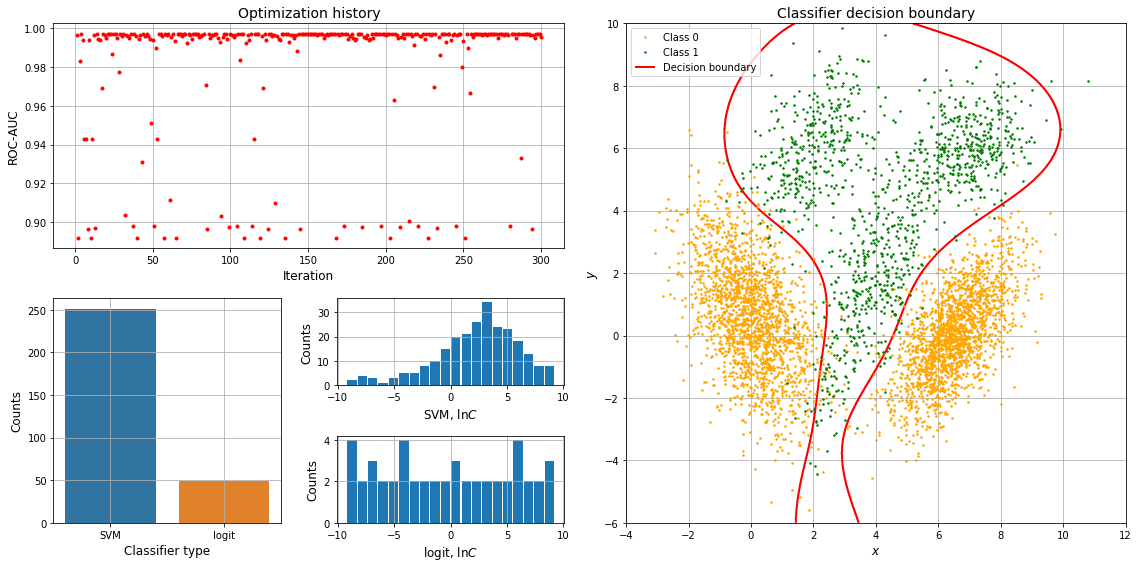

In [34]:
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :2])
ax.plot(range(1, len(trials_clf2) + 1), [-x['result']['loss'] for x in trials_clf2], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf2, x)) for x in trials_clf2.trials]

ax = fig0.add_subplot(gs[2:, 0])
sns.countplot(x=[x['type'] for x in samples], ax=ax)

ax.set_xlabel('Classifier type', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2, 1])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'SVM']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('SVM, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[3, 1])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'logit']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('logit, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ================================
# Plotting decision boundary

ax = fig0.add_subplot(gs[:, 2:])

# plt.contour is a bit tricky with legend labels, so it has to be constructed manually
legends = []

# Scattering sampled points and keeping their legend items
pts_class0, = ax.plot(X1[~flag, 0], X1[~flag, 1], label='Class 0', 
                      linewidth=0, marker='.', markersize=3, color='orange')
legends.append(pts_class0)
pts_class1, = ax.plot(X1[flag, 0], X1[flag, 1], label='Class 1', 
                      linewidth=0, marker='.', markersize=3, color='green')
legends.append(pts_class1)

# Decision boundary is build via plt.contour with single level line = 0.5, legend item added separately
cntr = ax.contour(xy_mesh2[0], xy_mesh2[1], 
                  clf2.predict_proba(xy_mesh2_features)[:, 1].\
                      reshape(xy_mesh2[0].shape[0], -1), 
                  levels = [0.5], colors='red', linewidths=2)
legends.append(cntr.legend_elements()[0][0])

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.set_title('Classifier decision boundary', fontsize=14)

ax.set_xlim(xlim2)
ax.set_ylim(ylim2)

ax.set_aspect('equal')
ax.grid(True)
ax.legend(legends, ['Class 0', 'Class 1', 'Decision boundary'])

# ================================

plt.tight_layout()

SVM heavily prevails over logit in this case - more than $5/6$ of all samples were drawn from SVM subspace. You can also see, as noted above, that sampling distribution of regularization constant $C$ is different for both classifiers. In case of logit it is nearly uniform, as `hyperopt` hasn't have enough trials to explore it properly, while for SVM there is a clear peak.

## Case 3: Tuning regression and backing up optimization history.

Ok, now we've covered most essential stuff. We can define hyperspaces and target functions of arbitrary complexity and succesfully traverse them to find optimal point. What else is there to learn?

One particularly annoying thing is inability to stop optimization at any given point. We pass `max_evals` parameter to `fmin` and until it exhaust all sample points - we have no info about what is happening (thankfully, in latest version (0.1.2 at the moment of writing this) authors have added progress bar with current best target function value). We can always interrupt `fmin`, but in this case we'll receive no output. Luckily, history is saved in `Trials` object, and we can extract it with a little hassle.

Actually, `Trials` objects have another very cool feature: using them, we can resume optimization from last recorded step. Since it keeps all evaluation history, `fmin` takes it into account and you don't start from square one again. You can run optimization for, say, 100 steps, look at results, and if you think there is more potential - just pass to `fmin` your `Trials` instance and add another 100 steps. Pretty nice, isn't it?

Let's test it on a simple regression (for a change) problem. We'll load dataset with California houses prices and unleash the power of `hyperopt` on it.

### Loading data

Let's read the data into pandas DataFrame and take initial look.

In [35]:
dset = datasets.fetch_california_housing()
tot_df = pd.DataFrame(
    {k: dset['data'][:, ic] for (k, ic) in zip(dset['feature_names'], range(dset['data'].shape[1]))}
)
target = dset['target']

tot_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We won't be performing any EDA here - that's not the point of this tutorial. We'll also drop latitude and longitude as features requiring special treatment and useless as they're now.

In [36]:
tot_df.drop(['Latitude', 'Longitude'], axis=1, inplace=True, errors='ignore')

As usual, split dataset into two parts.

### Preparation

We won't be choosing between different regressors this time, and focus on one model: Random Forest. Aside from regressor hyperparameters tuning it might as well use `hyperopt` for feature selection, in a fashion.

Say, we're not sure if `AveOccup` is useful, or just noisy. Also we would like to see if there is a benefit from adding logarithms of the features. Let's find out.

#### Preparing new features

In [37]:
orig_features = list(tot_df.columns)
print(orig_features)

log_features = []
for x_feature in orig_features:
    log_features.append('_'.join([x_feature, 'log']))
    tot_df[log_features[-1]] = np.log(tot_df[x_feature])
    
print(log_features)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
['MedInc_log', 'HouseAge_log', 'AveRooms_log', 'AveBedrms_log', 'Population_log', 'AveOccup_log']


All right, we added logarithms of features. We also see that `AveOccup` (and it's logarithm) are the last on the lists of features, which will be used later.

#### Splitting dataset

Here we're splitting dataset into train, validation and test parts.

In [38]:
Xdf_tv, Xdf_test, y_tv, y_test = train_test_split(tot_df, target, test_size=5000, random_state=SEED)
Xdf_train, Xdf_val, y_train, y_val = train_test_split(Xdf_tv, y_tv, test_size=5000, random_state=SEED)

print('Test set size: {0}x{1}'.format(*Xdf_test.shape))
print('Validation set size: {0}x{1}'.format(*Xdf_val.shape))
print('Training set size: {0}x{1}'.format(*Xdf_train.shape))

Test set size: 5000x12
Validation set size: 5000x12
Training set size: 10640x12


#### Defining search space

We define two hyperparameters: one for whether to use `AveOccup`, another for whether to use logarithms of features. We also add polynomial features generation, and some tree-controlling hyperparameters (for example, `max_leaf_nodes` might be unconstrained or limited).

In [39]:
hp_space_reg = {
    'use_aveoccup': hp.choice('use_aveoccup', [False, True]), 
    'use_logs': hp.choice('use_logs', [False, True]), 
    'poly': {
        'degree': 1 + hp.randint('degree', 2 + 1)
    }, 
    'clf': {
        'max_leaf_nodes': hp.choice('max_leaf_nodes', [
            {
                'max_leaf_nodes': None
            }, 
            {
                'max_leaf_nodes': ho_scope.int(hp.quniform('max_leaf_nodes_constrained', 100, 500, q=100))
            }
        ]), 
        'min_samples_split': 2 + hp.randint('min_samples_split', 8 + 1), 
        'min_samples_leaf': 1 + hp.randint('min_samples_leaf', 9 + 1), 
        'max_features': hp.uniform('rf.max_features', 0.2, 0.8)
    }
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_reg)

{'clf': {'max_features': 0.7761458445827503,
  'max_leaf_nodes': {'max_leaf_nodes': 400},
  'min_samples_leaf': 2,
  'min_samples_split': 8},
 'poly': {'degree': 2},
 'use_aveoccup': True,
 'use_logs': False}

#### Defining model

First step in model construction is creating a list of features to use, then using `ColumnTransformer` to select them and generate polynomial combinations. Note, that here we use `interaction_only = True`, as tree-based models don't care about monotonic transformations (such as squaring positive variables). Also, we'll use a cool feature of Random Forest Regressor - it's ability to estimate own performance using Out-of-Bag samples, that's why for hyperparameter optimization we're setting `oob_score=True`.

In [40]:
def f_reg_rf(hps, n_trees=100, oob_score=True):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    n_trees : int > 0, number of trees in RandomForestClassifier
    oob_score : boolean, whether to calculate R2 score on OOB samples
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    global orig_features, log_features
    
    if hps['use_aveoccup']:
        if hps['use_logs']:
            features = orig_features + log_features
        else:
            features = orig_features
    else:
        if hps['use_logs']:
            features = orig_features[:-1] + log_features[:-1]
        else:
            features = orig_features[:-1]

    # ================
    
    model = Pipeline([
        ('feature_selector', ColumnTransformer(transformers=[
            (
                'select', 
                PolynomialFeatures(**hps['poly'], interaction_only=True, include_bias=False), 
                features
            )
        ], remainder='drop')), 
        ('clf', RandomForestRegressor(**f_unpack_dict(hps['clf']), n_estimators=n_trees, oob_score=oob_score, 
                                      criterion='mse', bootstrap=True, n_jobs=-1, random_state=SEED))
    ])
    
    return model

Now, depending on hyperparameters selection, our model will operate only on given set of features, and should one choice be more efficient - it will be favored by TPE sampler. Also, `n_estimators` is not tuned, since obviously the more trees there are - the higher is accuracy. We'll fix it to $100$ during optimization phase - it should not affect optimal hyperparameters choosing, but greatly increases performance.

#### Target function

Unlike in previous models, we'll use OOB $R_2$ score as target, so that we don't need to train 5 forests for cross-validation. This speeds up things considerably. We also use validation set to calculate both RMSE and $R_2$ on it. Note that, again, since we want $R_2$ to be maximized - the minus sign must be added.

In [41]:
def f_to_min_reg(hps, X, y, X_test, y_test, n_trees=100):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : training feature matrix
    y : training target array
    X_test : validation feature matrix
    y_test : validation target array
    n_trees : int > 0, number of trees in RandomForestClassifier
    
    Returns:
    ----------------
    : dict(
        'loss' : target function value (negative OOB R2 score)
        'status' : status of function evaluation
        'test_rmse' : validation set RMSE
        'test_r2' : validation set R2
    )
    """
    
    model = f_reg_rf(hps, n_trees, True).fit(X, y)
    
    return {
        'loss': -model.steps[-1][1].oob_score_, 
        'status': STATUS_OK, 
        'test_rmse': np.sqrt(mean_squared_error(y_test, model.predict(X_test))), 
        'test_r2': r2_score(y_test, model.predict(X_test))
    }

### Running optimization and backing up results

We'll run optimization for 20 steps for the start.

In [42]:
trials_reg = Trials()
best_reg = fmin(partial(f_to_min_reg, X=Xdf_train, y=y_train, X_test=Xdf_val, y_test=y_val), 
                hp_space_reg, algo=tpe.suggest, max_evals=20, 
                trials=trials_reg, rstate=np.random.RandomState(SEED))

100%|██████████| 20/20 [02:43<00:00,  8.31s/it, best loss: -0.6924423489558804]


Right... 20 steps for a fairly multidimensional hyperspace. Unlikely that we explored it properly. I'd say another 180 (200 in total) runs wouldn't hurt. But in order to use already accumulated data, and not start from scratch - we pass `Trials` object to `fmin`, and it picks up from where it left.

In [43]:
best_reg = fmin(partial(f_to_min_reg, X=Xdf_train, y=y_train, X_test=Xdf_val, y_test=y_val), 
                hp_space_reg, algo=tpe.suggest, max_evals=200, 
                trials=trials_reg, rstate=np.random.RandomState(SEED))

100%|██████████| 180/180 [19:29<00:00,  5.92s/it, best loss: -0.6936406490387628]


We can pickle `Trials` object to hard drive and safely shut down the computer, and afterwards read it back and resume optimization. Given that it usually takes a lot of time to properly explore complex hyperspaces you might want to do that in several runs, when you do not use your computer heavily.

Take a look on best hyperparameters set.

In [44]:
# Displaying best result
print('OOB R2 score: {0:.4f}; validation set R2: {1:.4f}, validation set RMSE: {2:.4f}'.\
      format(-trials_reg.best_trial['result']['loss'], trials_reg.best_trial['result']['test_r2'], 
             trials_reg.best_trial['result']['test_rmse']))
print('Best parameters:')
print(space_eval(hp_space_reg, best_reg))

OOB R2 score: 0.6936; validation set R2: 0.7043, validation set RMSE: 0.6270
Best parameters:
{'clf': {'max_features': 0.45783318450974253, 'max_leaf_nodes': {'max_leaf_nodes': 500}, 'min_samples_leaf': 6, 'min_samples_split': 9}, 'poly': {'degree': 3}, 'use_aveoccup': True, 'use_logs': False}


### Visualizing results

Well, we've got $R_2 \approx 0.7$, which is not so bad, given that it is for rather small forests of 100 trees. Let's see how our optimization fared.

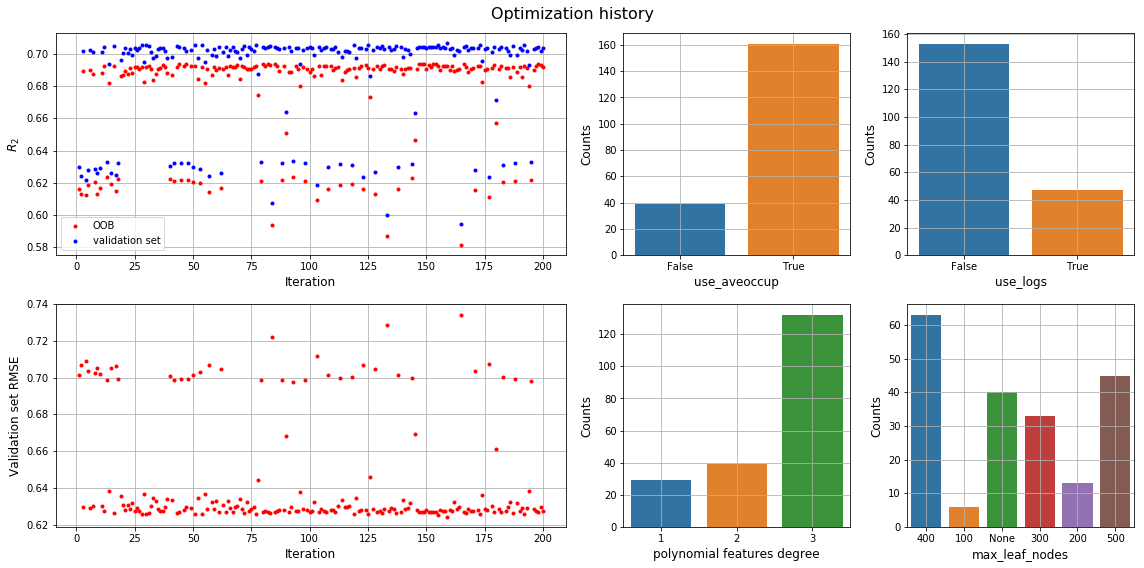

In [45]:
fig0 = plt.figure(figsize=(16, 8))
fig0.suptitle('Optimization history', fontsize=16)
gs = gridspec.GridSpec(nrows=2, ncols=4)

# ================================
# Plotting optimization histories

ax = fig0.add_subplot(gs[0, :2])
ax.plot(range(1, len(trials_reg) + 1), [-x['result']['loss'] for x in trials_reg], 
        color='red', marker='.', linewidth=0, label='OOB')
ax.plot(range(1, len(trials_reg) + 1), [x['result']['test_r2'] for x in trials_reg], 
        color='blue', marker='.', linewidth=0, label='validation set')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('$R_2$', fontsize=12)

ax.legend()
ax.grid(True)

# --------------------

ax = fig0.add_subplot(gs[1, :2])
ax.plot(range(1, len(trials_reg) + 1), [x['result']['test_rmse'] for x in trials_reg], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Validation set RMSE', fontsize=12)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_reg, x)) for x in trials_reg.trials]

# ----------------

ax = fig0.add_subplot(gs[0, 2])
sns.countplot(x=[x['use_aveoccup'] for x in samples], ax=ax)

ax.set_xlabel('use_aveoccup', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[0, 3])
sns.countplot(x=[x['use_logs'] for x in samples], ax=ax)

ax.set_xlabel('use_logs', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[1, 2])
sns.countplot(x=[x['degree'] for x in samples], ax=ax)

ax.set_xlabel('polynomial features degree', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[1, 3])
sns.countplot(x=[str(x['max_leaf_nodes']) for x in samples], ax=ax)

ax.set_xlabel('max_leaf_nodes', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# # ================================

fig0.tight_layout(rect=[0, 0, 1, 0.96])

Interesting. Seems that `AveOccup` is a useful feature after all, while logarithms are not favored. Also, constraining tree depth looks beneficial, as well as adding cubic feature combinations.

Last step - to see how model performed on test set.

### Test set performance

Using full capacity of model here - 2000 trees.

In [46]:
reg = f_reg_rf(space_eval(hp_space_reg, best_reg), n_trees=2000, oob_score=True)
reg.fit(pd.concat([Xdf_train, Xdf_val], axis=0), np.hstack([y_train, y_val]))
reg_pred = reg.predict(Xdf_test)

print('Model OOB R2 score: {0:.4f}'.format(reg.steps[-1][1].oob_score_))
print('Model test set R2 score: {0:.4f}'.format(r2_score(y_test, reg_pred)))
print('Model test set RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, reg_pred))))

Model OOB R2 score: 0.7017
Model test set R2 score: 0.7071
Model test set RMSE: 0.6297


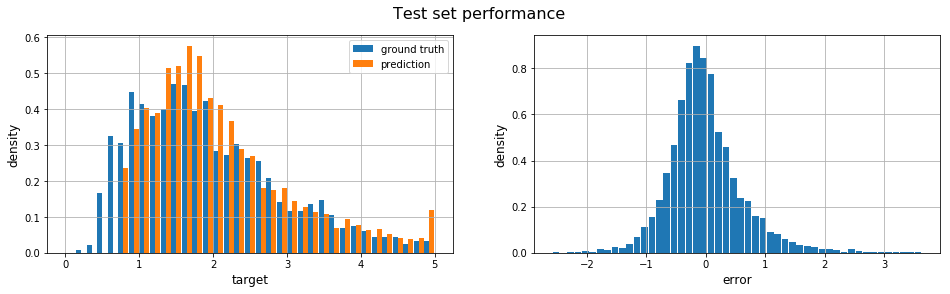

In [47]:
fig0 = plt.figure(figsize=(16, 4))
fig0.suptitle('Test set performance', fontsize=16)
gs = gridspec.GridSpec(nrows=1, ncols=2)

# ================================

ax = fig0.add_subplot(gs[0, 0])
ax.hist([y_test, reg_pred], bins=35, range=(0, 5), rwidth=0.95, label=['ground truth', 'prediction'], 
        density=True)

ax.set_xlabel('target', fontsize=12)
ax.set_ylabel('density', fontsize=12)

ax.grid(True)
ax.legend()

# ================================

ax = fig0.add_subplot(gs[0, 1])
ax.hist(y_test - reg.predict(Xdf_test), bins=50, rwidth=0.9, density=True)

ax.set_xlabel('error', fontsize=12)
ax.set_ylabel('density', fontsize=12)

ax.grid(True)

Well, distributions are not exactly same, but look fairly close. For some reason our regressor have no low-value predictions at all - worth investigating. But that's for another time.

## Conclusion

Congratulations, you've reached the end of this far too long tutorial! Time for recap.

  - `hyperopt` is a method of stochastic target function minimization, which uses bayesian approach for intelligent points sampling from search space. It adjusts prior distribution using history of target function evaluations, concentrating probability mass in the region where function performs better;
  - To run optimization task you have to define your search space and target function;
  - It is used extensively in machine learning, since it usually yields better results than Random Search (which is better than Grid Search) with same amount of time invested.

**Pros**:

  - More efficient search space exploration, likely to yield better results in less time;
  - Ability to build search spaces of arbitrary complexity, mixing all possible types of variables and branching into subspaces as needed;
  - Ability to make custom-tailored target function, so that you can optimize any aspect of your model as you desire.

**Cons**:
  - Complex search spaces might take a lot of time to get properly explored. Each additional dimension, on average, would require additional runs for optimization to converge;
  - Hyperparameters are treated independently - that might be one of greatest weaknesses of `hyperopt`. If some of hyperparameters are tightly coupled with strong anticorrelation - you might even get worse results than in case of simple Random Search;
  - TPE takes some time to analyze evaluation history and suggest a new point, and the longer the history - the longer the time it takes. This is negligibly small if one step takes several minutes, but might be noticeable if evaluation is quick and runs for many trials.

### Hints

  - There is a rule of thumb that for proper search space exploration you would require around 25 runs per dimension to converge. It is entirely heuristical, but might help to estimate how many steps you would need;
  - Always back up your results into `Trials` object, and possibly pickle it to hard drive. It is very frustrating to lose several hours of optimization due to a power cut or OS freezing;
  - Check carefully sign of your target function. Shouldn't a minus be there?
  - Don't use full capacity of your model for hyperparameter tuning. This means: your don't need 1000 trees in your XGBoost, nor do you need all 8 million samples of your training set. It is very unlikely that optimization on a reduced set/capacity would yield significantly different results, while computation time would be much lower;
  - **MOST IMPORTANT**: Never substitute proper feature engineering with extensive hyperparameter optimization. Former is much more important - untuned model with great features easily outperforms heavily optimized model without intelligent design. Do some EDA, try things, find out what works, what might work and what is garbage, and then, before you go to sleep - launch optimization for the night. Not the other way around.

## What's next?

There is a package [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn), which eases setting up optimization tasks using `sklearn` models. Many of estimators are wrapped with target functions and default and configurable search spaces. I personally don't use it, but it is very well worth exploring.

`hyperopt` can be run in parallel, but this takes some tambourine playing to set up. You'll have to use MongoDB trials objects instead of native ones. [Here](https://blog.goodaudience.com/on-using-hyperopt-advanced-machine-learning-a2dde2ccece7) is an introductory article on how to set this up. Again, might greatly accelerate things, or might not, if you use all your cores for speeding up a single optimization step (say, multicore RandomForest fitting).

`hyperopt` is not the only library for bayesian optimization, and in fact some people prefer other ways, especially due to `hyperopt` treating hyperparameters as independent. There is [SMAC](https://automl.github.io/SMAC3/stable/manual.html) and other methods, highlighted in [paper](https://arxiv.org/pdf/1807.02811.pdf). As with ML, there is no silver bullet.

That would be all from me. Many thanks for reading, hope you liked it!